<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#План-проекта" data-toc-modified-id="План-проекта-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>План проекта</a></span></li><li><span><a href="#Загрузка-библиотек" data-toc-modified-id="Загрузка-библиотек-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Загрузка библиотек</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Загрузка данных</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных-из-файла" data-toc-modified-id="Загрузка-данных-из-файла-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Загрузка данных из файла</a></span></li><li><span><a href="#Ресемплирование-данных" data-toc-modified-id="Ресемплирование-данных-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Ресемплирование данных</a></span></li></ul></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Подбор-и-обучение-моделей" data-toc-modified-id="Подбор-и-обучение-моделей-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Подбор и обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Модель-Prophet" data-toc-modified-id="Модель-Prophet-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Модель Prophet</a></span></li><li><span><a href="#Модель-Линейной-регрессии" data-toc-modified-id="Модель-Линейной-регрессии-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Модель Линейной регрессии</a></span></li><li><span><a href="#Модель-DecisionTreeRegressor" data-toc-modified-id="Модель-DecisionTreeRegressor-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Модель DecisionTreeRegressor</a></span></li><li><span><a href="#Модель-XGBRegressor" data-toc-modified-id="Модель-XGBRegressor-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Модель XGBRegressor</a></span></li><li><span><a href="#Сравнение-моделей" data-toc-modified-id="Сравнение-моделей-6.5"><span class="toc-item-num">6.5&nbsp;&nbsp;</span>Сравнение моделей</a></span></li></ul></li></ul></div>

# Временные ряды. Проект

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

Данные лежат в файле `datasets/taxi.csv`
Количество заказов находится в столбце `num_orders` (от англ. number of orders, «число заказов»).

## План проекта

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Загрузка библиотек

In [1]:
# обновляю библиотеку

!pip install --upgrade scikit-learn -q

In [2]:
# устанавливаю библиотеку

!pip install xgboost -q

In [3]:
# устанавливаю библиотеку

!pip install prophet -q

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.api as sm
import xgboost as xgb

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.tsa.stattools as ts


from prophet import Prophet

from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse

from sklearn.model_selection import (train_test_split,
                                     TimeSeriesSplit,
                                     cross_val_score,
                                    GridSearchCV)

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error

from xgboost import XGBRegressor

RANDOM_STATE = 42

## Загрузка данных

### Загрузка данных из файла

Сначала просто прочтем данные:
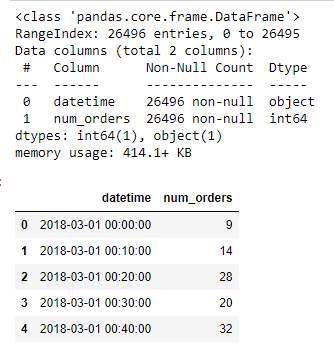

Теперь сразу при загрузке обработаем колонку с датой, превратив ее в индексы.

In [5]:
try:
    data = pd.read_csv('C:\\Users\\ElenaB\\Projects\\pj_16\\taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

data.info()    
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
# проверим наши данные на хронологию

data.sort_index(inplace=True)
print(data.index.is_monotonic)

True


Данные отсортированы корректно. Исходя из первых пяти строк, сейчас данные зафиксированы для каждых 10 минут.

### Ресемплирование данных

Необходимо произвести ресемплирование данных к 1 часу.

Поскольку данные снимались каждые десять минут, можно предположить, что это количество новых, необработанных заказов такси. Поэтому после ресемплирования данные будем суммировать.

In [7]:
data_l = data.resample('1H').sum() 
data_l.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Наши данные теперь обработаны за период с 0 часов 1 марта 2018 года по 23 часа ровно 31 августа 2018 года.

Построим общий график данных.

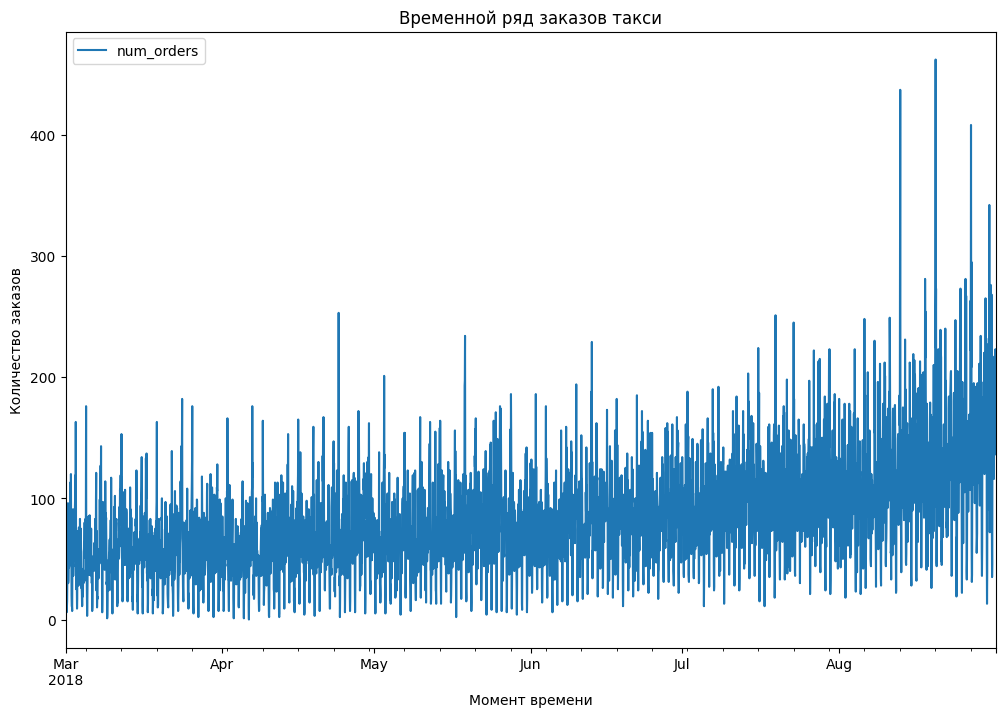

In [8]:
plt.rcParams['figure.figsize'] = [12, 8]
data_l.plot()
plt.title('Временной ряд заказов такси')
plt.xlabel('Момент времени')
plt.ylabel('Количество заказов')
plt.show()

## Анализ данных

Воспользуемся методом библиотеки statsmodels, и посмотрим на компоненты нашего временного ряда.

In [9]:
decomposed = sm.tsa.seasonal_decompose(data_l)

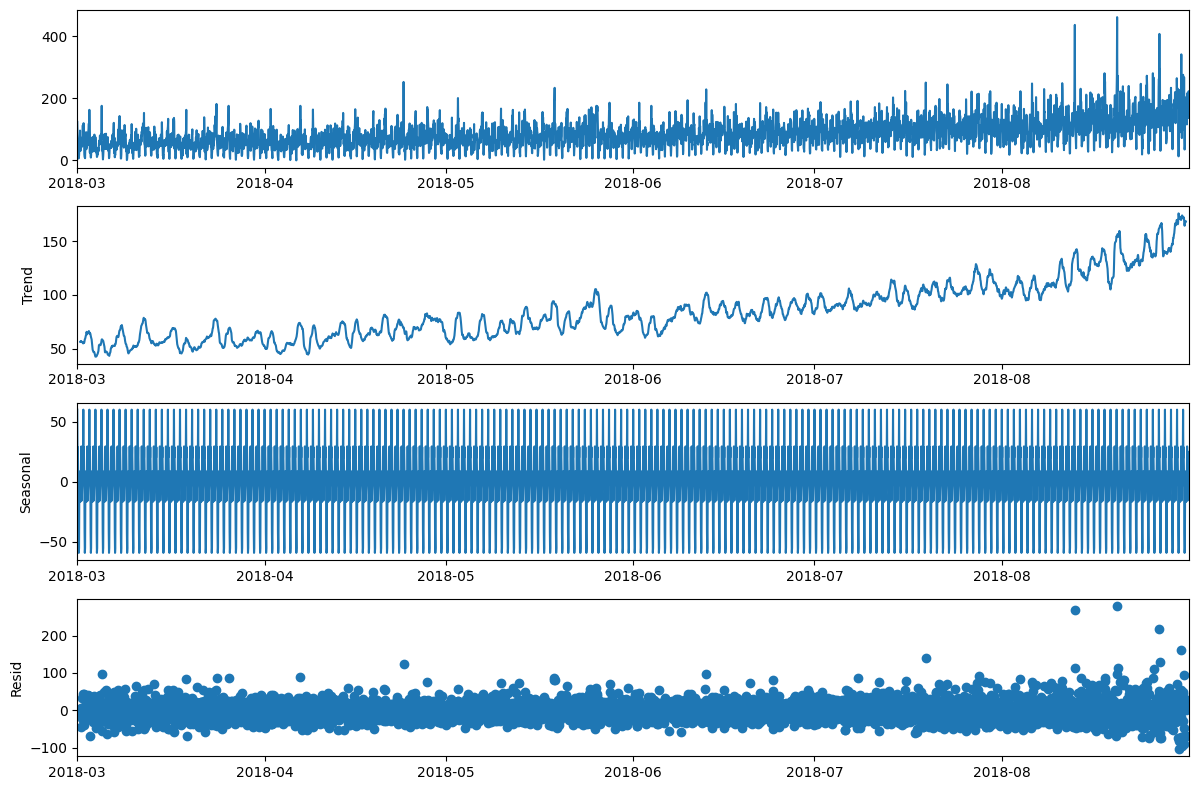

In [10]:
decomposed.plot()
plt.show()

В наблюдаемых данных есть тренд на увеличение среднего значения заказов. А также есть сезонность. Причем, судя по частоте пиков, с очень небольшим периодом. Попробуем сузить интервал последовательно до месяца, недели, дня, чтобы определить инветрал сезонности.

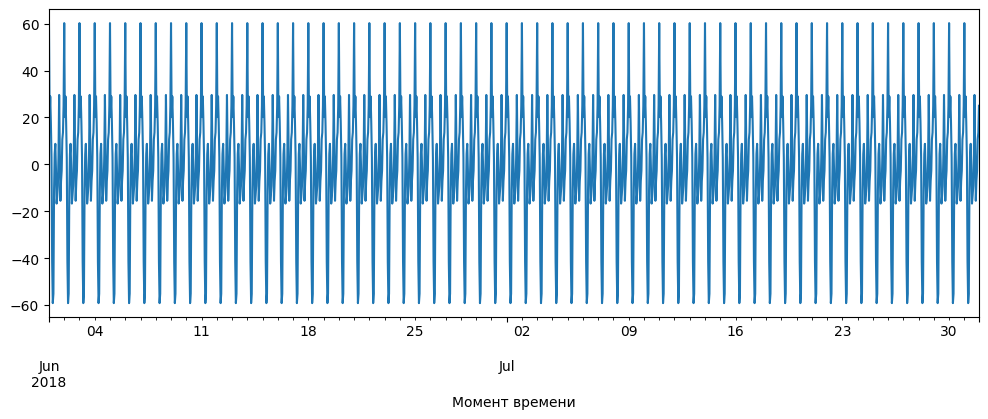

In [11]:
plt.rcParams['figure.figsize'] = [12, 4]
decomposed.seasonal['2018-06':'2018-07'].plot()
plt.xlabel('Момент времени')
plt.show()

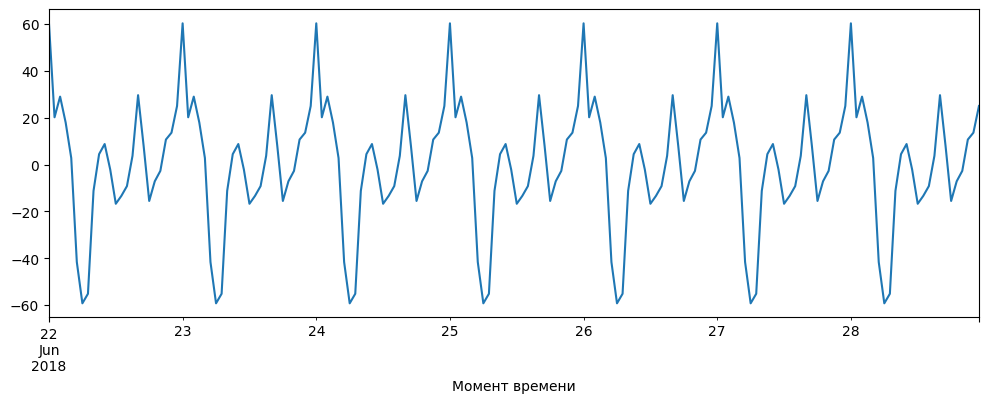

In [12]:
decomposed.seasonal['2018-06-22':'2018-06-28'].plot()
plt.xlabel('Момент времени')
plt.show()

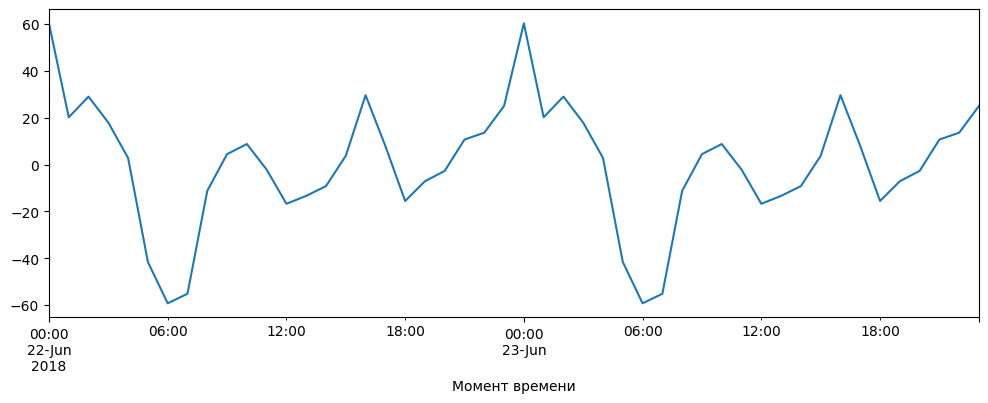

In [13]:
decomposed.seasonal['2018-06-22':'2018-06-23'].plot()
plt.xlabel('Момент времени')
plt.show()

Сезонность получается с однодневным интервалом: на 6:00 приходится минимум числа заказов, на 0:00 приходится максимум.

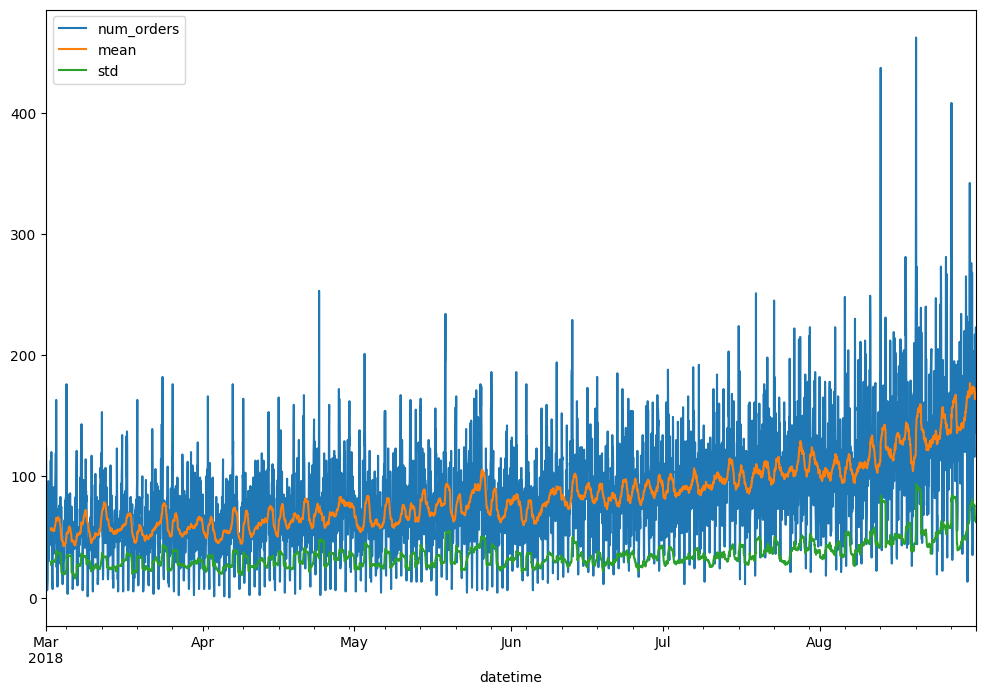

In [14]:
plt.rcParams['figure.figsize'] = [12, 8]
data_l['mean'] = data_l['num_orders'].rolling(24).mean()
data_l['std'] = data_l['num_orders'].rolling(24).std()
data_l.plot()
plt.show()

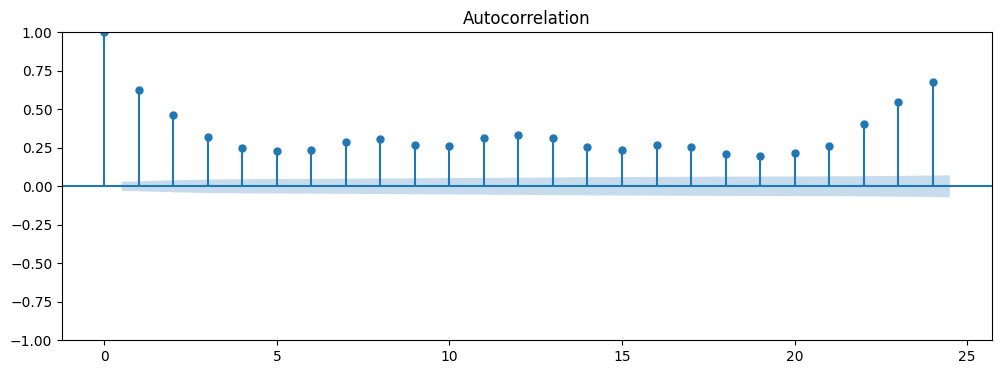

In [15]:
#

plt.rcParams['figure.figsize'] = [12, 4]
fig = tsaplots.plot_acf(data_l['num_orders'], lags=24)
plt.show() 

## Подбор и обучение моделей

Для предсказания данных во временных рядах можно использовать как общие модели машинного обучения, так и специализированные библиотеки. Попробуем воспользоваться для предсказания: моделью Линейной регрессии, моделью градиентного бустинга, библиотекой Prophet.

В качестве тестовых данных нам необходимо использовать 10% всей выборки. И RMSE нашей модели должна быть меньше 48.

### Модель Prophet

Для этой модели важны названия столбцов с данными. Поэтому придется произвести некоторые манипуляции.

In [16]:
# возьмем копию исходного датафрейма

data_pr = data.resample('1H').sum().reset_index().copy()
data_pr.head()

,datetime,num_orders
0,2018-03-01 00:00:00,124
1,2018-03-01 01:00:00,85
2,2018-03-01 02:00:00,71
3,2018-03-01 03:00:00,66
4,2018-03-01 04:00:00,43


In [17]:
# заменим названия столбцов

data_pr.columns = ['ds','y']

In [18]:
# разделим данные на выборки

TEST_SIZE = int(0.1 * data_pr.shape[0])

train_pr = data_pr.iloc[:-TEST_SIZE] 
test_pr = data_pr.iloc[-TEST_SIZE:] 

In [19]:
# инициализируем и обучим модель

model_pr = Prophet()
model_pr.fit(train_pr)

19:43:47 - cmdstanpy - INFO - Chain [1] start processing
19:43:47 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
# создадим датафрейс с предсказаниями модели

future_pr = model_pr.make_future_dataframe(periods=TEST_SIZE, freq='h')
forecast = model_pr.predict(future_pr)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-03-01 00:00:00,54.462436,55.657648,120.726415,54.462436,54.462436,34.116227,34.116227,34.116227,32.110760,32.110760,32.110760,2.005467,2.005467,2.005467,0.0,0.0,0.0,88.578663
1,2018-03-01 01:00:00,54.468619,57.616949,119.394263,54.468619,54.468619,34.196482,34.196482,34.196482,32.695030,32.695030,32.695030,1.501453,1.501453,1.501453,0.0,0.0,0.0,88.665101
2,2018-03-01 02:00:00,54.474802,54.030380,115.460287,54.474802,54.474802,30.315832,30.315832,30.315832,29.343994,29.343994,29.343994,0.971838,0.971838,0.971838,0.0,0.0,0.0,84.790634
3,2018-03-01 03:00:00,54.480985,38.592427,102.697784,54.480985,54.480985,16.238891,16.238891,16.238891,15.812423,15.812423,15.812423,0.426468,0.426468,0.426468,0.0,0.0,0.0,70.719876
4,2018-03-01 04:00:00,54.487168,12.288012,77.181061,54.487168,54.487168,-9.604514,-9.604514,-9.604514,-9.479903,-9.479903,-9.479903,-0.124610,-0.124610,-0.124610,0.0,0.0,0.0,44.882655


In [21]:
# соберем данные из предсказния в датафрейм и посчитаем метрику

prophet_pred = pd.DataFrame({"Date":forecast['ds'], 
                             "Pred":forecast["yhat"]})

prophet_pred = prophet_pred.set_index("Date")

prophet_rmse_error_train = rmse(test_pr['y'], prophet_pred[-TEST_SIZE:]['Pred'])

prophet_rmse_error_test = rmse(train_pr['y'], prophet_pred[:-TEST_SIZE]['Pred'])

print("Train")
print(f'RMSE Error: {prophet_rmse_error_train}')

print("Test")
print(f'RMSE Error: {prophet_rmse_error_test}')

Train
RMSE Error: 48.31933023962945
Test
RMSE Error: 24.585687038919588


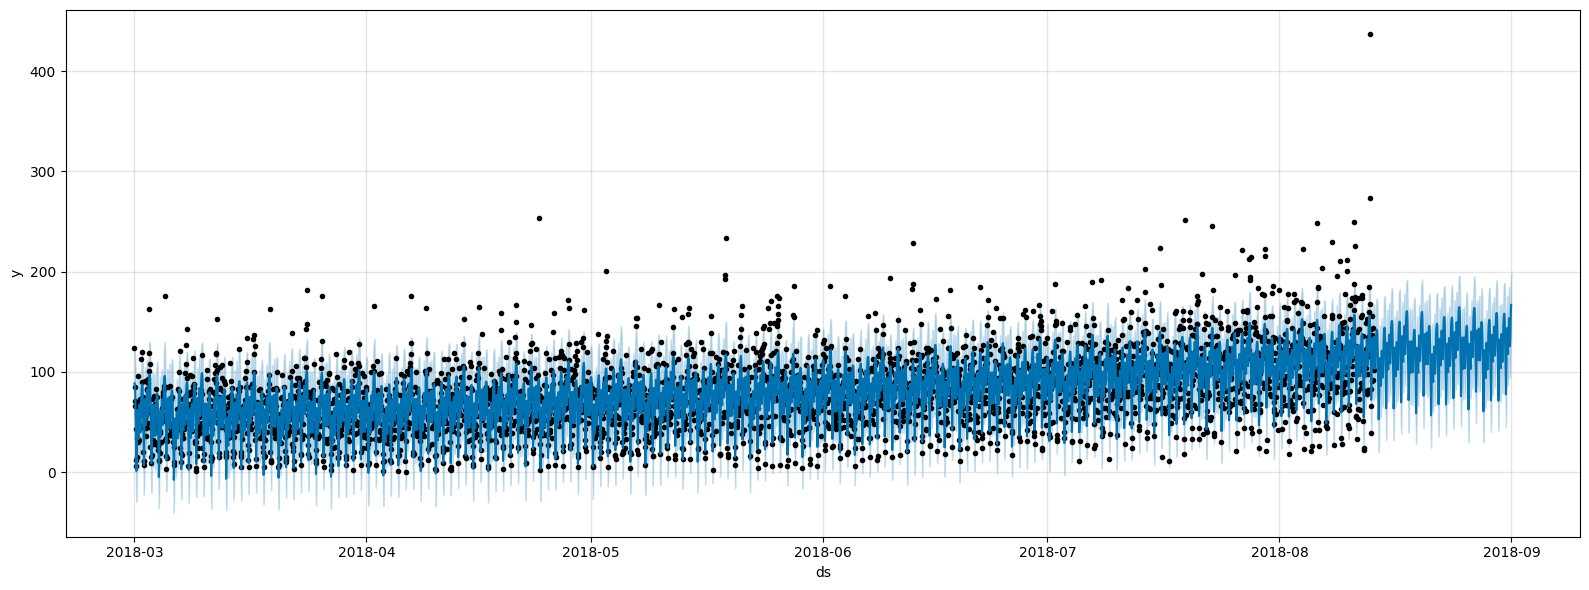

In [22]:
# построим общий график предсказания

model_pr.plot(forecast, figsize=(16, 6))
plt.show()

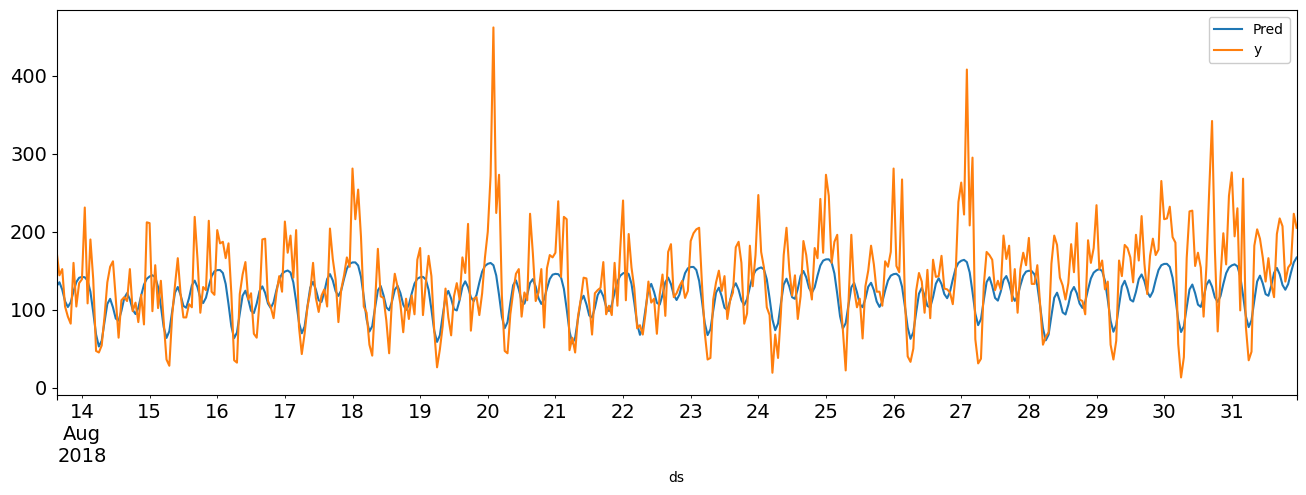

In [23]:
# 

plt.figure(figsize=(16,5))

prophet_pred[-TEST_SIZE:]['Pred'].plot(fontsize=14)
test_pr = test_pr.set_index(['ds'])
test_pr['y'].plot(fontsize=14)
plt.legend(loc = 'best', framealpha = 1)
plt.show()

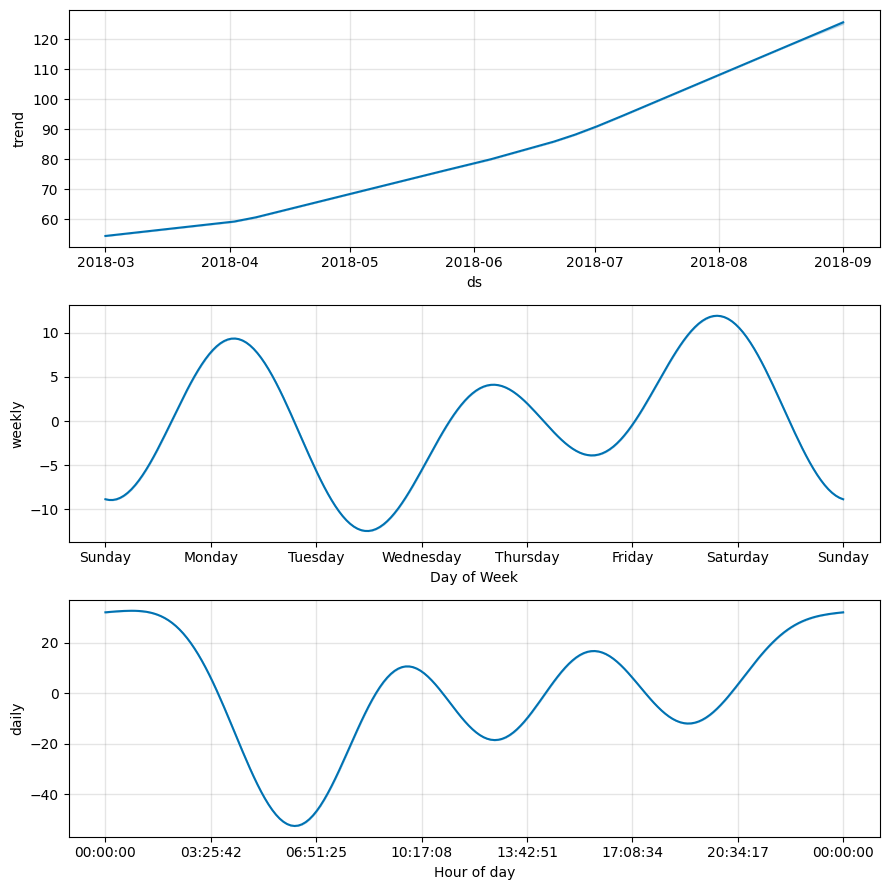

In [24]:
# посмотрим на компоненты предсказания

fig = model_pr.plot_components(forecast)

Модель Prophet увидела в данных и недельную сезонность, и дневную. Пики минимального и максимального количества заказов для ежедневного цикла совпадают с общим анализом данных из statsmodel. 

### Модель Линейной регрессии

Все признаки нам нужно будет подготовить самим, но зато можно подобрать количество колонок с лагом. И разделить выборку.

In [25]:
# определим функцию для создания признаков

def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [26]:
# определим функцию для тестирования количества признаков в модели

def model_preds (data_x, model):
    
    train, test = train_test_split(data_x, shuffle=False, test_size=0.1, random_state=RANDOM_STATE)
    train = train.dropna()
    
    X_train = train.drop(['num_orders'], axis=1)
    y_train = train['num_orders']
    X_test = test.drop(['num_orders'], axis=1)
    y_test = test['num_orders']

    model.fit(X_train, y_train)

    pred = model.predict(X_test)

    rmse = root_mean_squared_error(pred, y_test)
    
    tscv = TimeSeriesSplit(n_splits=5)
    scores = cross_val_score(estimator=model, cv=tscv, X=X_train, 
                             y=y_train, scoring='neg_root_mean_squared_error').mean()
    
    return rmse, scores, pred

In [27]:
# произведем поиск количества признаков для лучшей Линейной модели

m_lin = LinearRegression()

for max_lag in range (1, 23):
    make_features(data_l, max_lag, 1)
    model_preds(data_l, m_lin)
    
    print('Размер лага [{}]'.format(max_lag), 
          "Значение RMSE на тестовой выборке:" , round((model_preds(data_l, m_lin)[0]), 2),
         "Средняя ошибка на кросс-валидации:", round(abs(model_preds(data_l, m_lin)[1]), 2))

Размер лага [1] Значение RMSE на тестовой выборке: 50.6 Средняя ошибка на кросс-валидации: 31.35
Размер лага [2] Значение RMSE на тестовой выборке: 50.66 Средняя ошибка на кросс-валидации: 31.37
Размер лага [3] Значение RMSE на тестовой выборке: 49.78 Средняя ошибка на кросс-валидации: 31.22
Размер лага [4] Значение RMSE на тестовой выборке: 49.46 Средняя ошибка на кросс-валидации: 31.14
Размер лага [5] Значение RMSE на тестовой выборке: 49.35 Средняя ошибка на кросс-валидации: 31.23
Размер лага [6] Значение RMSE на тестовой выборке: 49.52 Средняя ошибка на кросс-валидации: 31.16
Размер лага [7] Значение RMSE на тестовой выборке: 49.54 Средняя ошибка на кросс-валидации: 31.26
Размер лага [8] Значение RMSE на тестовой выборке: 49.45 Средняя ошибка на кросс-валидации: 31.29
Размер лага [9] Значение RMSE на тестовой выборке: 49.33 Средняя ошибка на кросс-валидации: 30.87
Размер лага [10] Значение RMSE на тестовой выборке: 48.88 Средняя ошибка на кросс-валидации: 30.88
Размер лага [11] Зна

В общем, логично. При сезонности в 1 день, ожидаемо, что при лаге в 23 часа данные практически сойдутся.

### Модель DecisionTreeRegressor

Можно воспользоваться нашими функциями для линейной модели, и посмотреть на значения.

In [28]:
m_dtr = DecisionTreeRegressor(random_state=RANDOM_STATE)

data_dtr =  data.resample('1H').sum()

for max_lag in range (1, 23):
    make_features(data_dtr, max_lag, 1)
    model_preds(data_dtr, m_dtr)
    
    print('Размер лага [{}]'.format(max_lag), 
          "Значение RMSE на тестовой выборке:" , round((model_preds(data_dtr, m_dtr)[0]), 2),
         "Средняя ошибка на кросс-валидации:", round(abs(model_preds(data_dtr, m_dtr)[1]), 2))

Размер лага [1] Значение RMSE на тестовой выборке: 51.54 Средняя ошибка на кросс-валидации: 32.34
Размер лага [2] Значение RMSE на тестовой выборке: 54.72 Средняя ошибка на кросс-валидации: 31.91
Размер лага [3] Значение RMSE на тестовой выборке: 55.94 Средняя ошибка на кросс-валидации: 31.56
Размер лага [4] Значение RMSE на тестовой выборке: 51.64 Средняя ошибка на кросс-валидации: 32.48
Размер лага [5] Значение RMSE на тестовой выборке: 60.36 Средняя ошибка на кросс-валидации: 32.45
Размер лага [6] Значение RMSE на тестовой выборке: 51.0 Средняя ошибка на кросс-валидации: 32.82
Размер лага [7] Значение RMSE на тестовой выборке: 53.66 Средняя ошибка на кросс-валидации: 34.37
Размер лага [8] Значение RMSE на тестовой выборке: 49.71 Средняя ошибка на кросс-валидации: 34.46
Размер лага [9] Значение RMSE на тестовой выборке: 49.78 Средняя ошибка на кросс-валидации: 35.1
Размер лага [10] Значение RMSE на тестовой выборке: 47.65 Средняя ошибка на кросс-валидации: 33.91
Размер лага [11] Знач

В целом, модель показывает себя гораздо хуже.

### Модель XGBRegressor

In [29]:
m_xgb = XGBRegressor(random_state=RANDOM_STATE)

data_xgb =  data.resample('1H').sum()

for max_lag in range (1, 23):
    make_features(data_xgb, max_lag, 1)
    model_preds(data_xgb, m_xgb)
    
    print('Размер лага [{}]'.format(max_lag), 
          "Значение RMSE на тестовой выборке:" , round((model_preds(data_xgb, m_xgb)[0]), 2),
         "Средняя ошибка на кросс-валидации:", round(abs(model_preds(data_xgb, m_xgb)[1]), 2))

Размер лага [1] Значение RMSE на тестовой выборке: 47.75 Средняя ошибка на кросс-валидации: 27.19
Размер лага [2] Значение RMSE на тестовой выборке: 49.33 Средняя ошибка на кросс-валидации: 27.23
Размер лага [3] Значение RMSE на тестовой выборке: 44.77 Средняя ошибка на кросс-валидации: 26.87
Размер лага [4] Значение RMSE на тестовой выборке: 45.43 Средняя ошибка на кросс-валидации: 26.37
Размер лага [5] Значение RMSE на тестовой выборке: 46.31 Средняя ошибка на кросс-валидации: 26.69
Размер лага [6] Значение RMSE на тестовой выборке: 45.36 Средняя ошибка на кросс-валидации: 26.36
Размер лага [7] Значение RMSE на тестовой выборке: 45.41 Средняя ошибка на кросс-валидации: 26.34
Размер лага [8] Значение RMSE на тестовой выборке: 44.55 Средняя ошибка на кросс-валидации: 26.62
Размер лага [9] Значение RMSE на тестовой выборке: 45.84 Средняя ошибка на кросс-валидации: 26.43
Размер лага [10] Значение RMSE на тестовой выборке: 44.2 Средняя ошибка на кросс-валидации: 26.6
Размер лага [11] Знач

Начиная с 4 и более колонок со смещениями, модель предсказывает примерно одинаково.

### Сравнение моделей

In [35]:
test_pr['lin_preds'] = model_preds(data_l, m_lin)[2][:-1]
test_pr['dtr_preds'] = model_preds(data_dtr, m_dtr)[2][:-1]
test_pr['xgb_preds'] = model_preds(data_xgb, m_xgb)[2][:-1]

<div class="alert alert-info">
<font size="4", color = "black"><b>✍ Комментарий студента v.0</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> У меня не совпала размерность данных. В результате из модели Пророка вышло 441 строка. А в результате моделей регрессоров - 442 строки. Какая-то проблема округления?

Text(0.5, 1.0, 'Сравнение предсказаний между различными моделями')

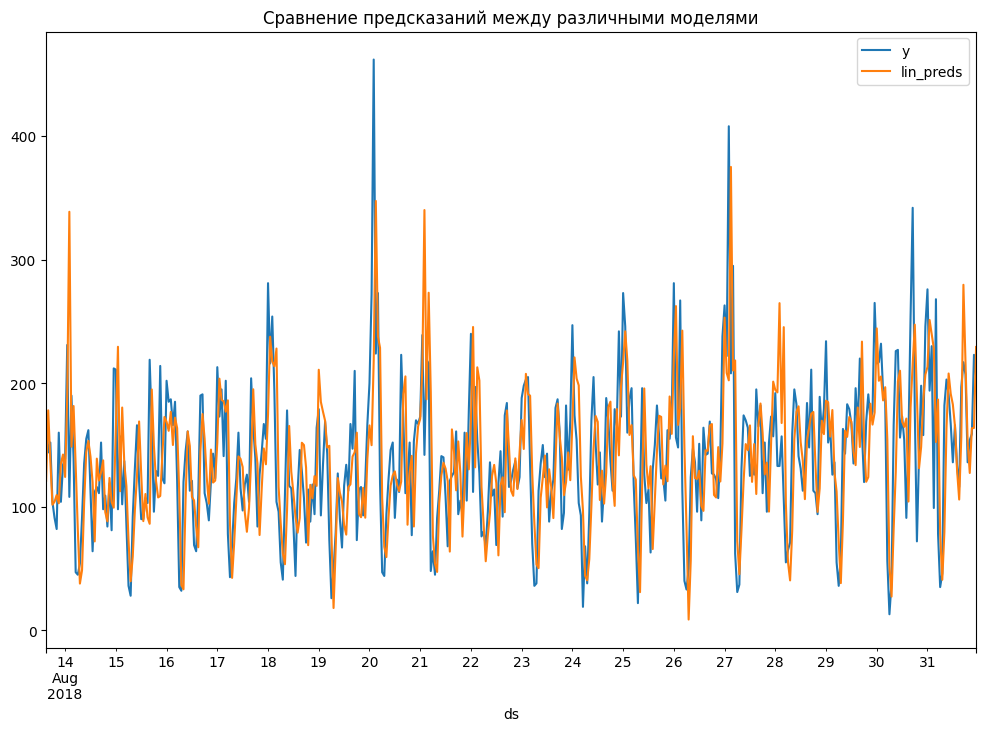

In [31]:
plt.rcParams['figure.figsize'] = [12, 8]
test_pr[['y', 'lin_preds']].plot()
plt.title("Сравнение предсказаний между различными моделями")

Text(0.5, 1.0, 'Сравнение предсказаний между различными моделями')

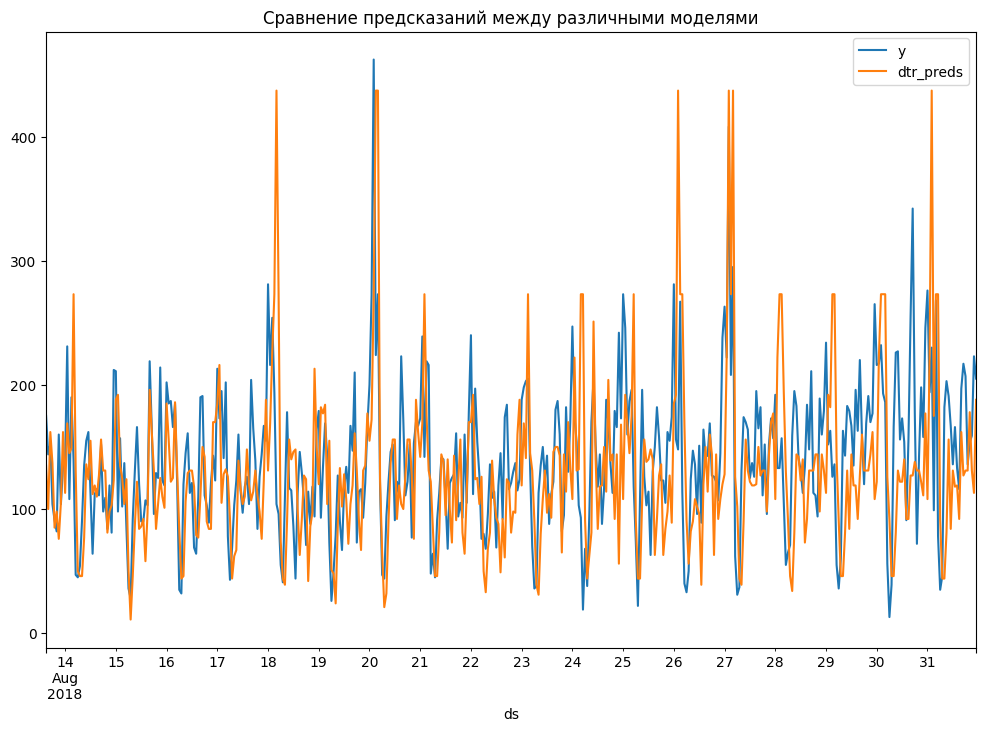

In [32]:
plt.rcParams['figure.figsize'] = [12, 8]
test_pr[['y', 'dtr_preds']].plot()
plt.title("Сравнение предсказаний между различными моделями")

Text(0.5, 1.0, 'Сравнение предсказаний между различными моделями')

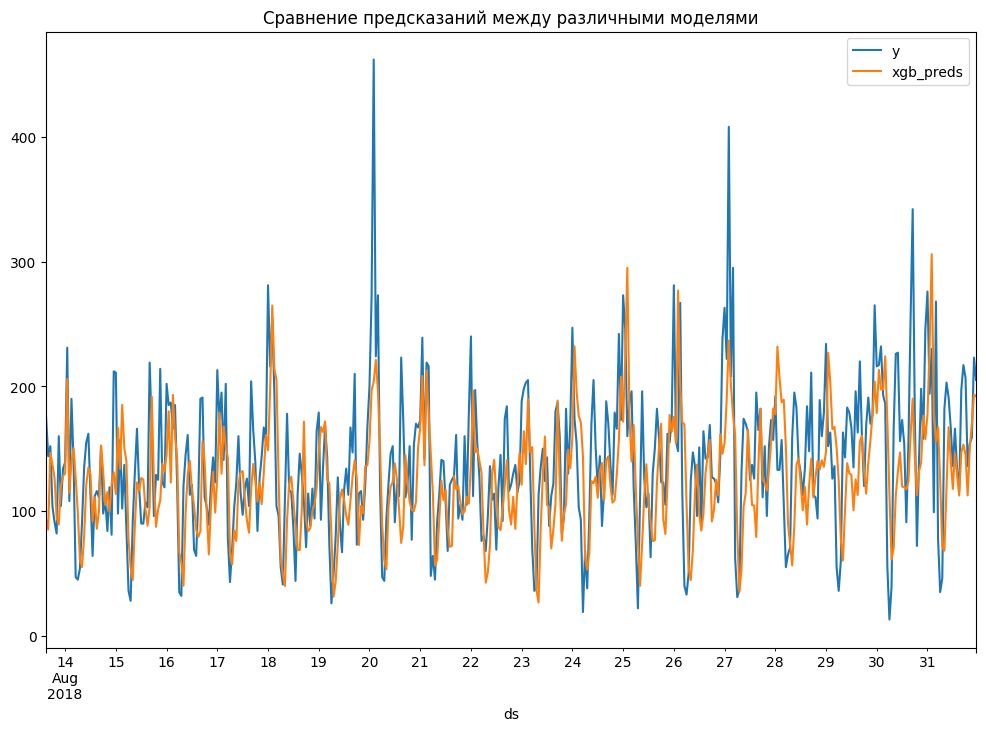

In [33]:
plt.rcParams['figure.figsize'] = [12, 8]
test_pr[['y', 'xgb_preds']].plot()
plt.title("Сравнение предсказаний между различными моделями")

В целом, все модели смогли уловить ключевые зависимости временного ряда. Но наибольшим отклонением от реальных данных обладает модель DecisionTreeRegressor. А вот линейная модель показала подозрительно низкое отклонение.

<div class="alert alert-info">
<font size="4", color = "black"><b>✍ Комментарий студента v.0</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Я понимаю, что проект полусырой. Я не пробовала разобраться с моделями ARIMA. Я не смогла разобраться с GridSearch. У меня были проблемы с функциями, данными, графиками. Я бы хотела получить направления, в котором нужно улучшить проект. Пока у меня слишком сумбурно все.